In [1]:
import pickle
# import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import tqdm.notebook as tqdm

import fair
from fair import multi_ebm
from fair.energy_balance_model import EnergyBalanceModel


## Part 1: Setup - effective radiative forcings

In [12]:
# AR6 assessed ERFs for SSP1-2.6
df_forcing_126 = pd.read_csv('files/ERF_ssp126_1750-2500.csv', index_col='year').loc[1850:2100]
df_forcing_126


,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,
1850,0.139966,0.049382,0.007358,7.958010e-08,0.030000,0.004539,0.000000,-0.006275,-0.071873,0.006886,-0.031205,0.194333,0.007528,0.128779,0.201861,0.330640
1851,0.142307,0.049486,0.007656,8.228277e-08,0.031016,0.004548,0.000000,-0.005063,-0.063404,0.006246,-0.031907,0.197859,0.002068,0.140886,0.199927,0.340813
1852,0.144956,0.049947,0.007954,8.533412e-08,0.032032,0.004591,0.000000,-0.004535,-0.059701,0.005972,-0.032610,0.191554,0.001257,0.148605,0.192811,0.341415
1853,0.147334,0.050708,0.008331,8.839851e-08,0.033049,0.004661,0.000000,-0.005117,-0.063726,0.006264,-0.033313,0.010986,-0.008868,0.148191,0.002118,0.150310
1854,0.149366,0.051522,0.008720,9.147118e-08,0.034065,0.004736,0.000000,-0.007101,-0.078993,0.007432,-0.034015,-0.022961,-0.022721,0.135732,-0.045682,0.090050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,2.688951,0.199271,0.280329,1.620525e-01,0.143228,0.018316,0.032242,-0.120027,-0.027364,0.003287,-0.170111,0.000000,-0.018021,3.210175,-0.018021,3.192153
2097,2.674907,0.196563,0.281117,1.605280e-01,0.142087,0.018067,0.032086,-0.119165,-0.022699,0.002933,-0.169348,0.000000,-0.025076,3.197076,-0.025076,3.172000
2098,2.661078,0.193926,0.281891,1.590254e-01,0.140945,0.017825,0.031930,-0.118303,-0.018142,0.002579,-0.168562,0.000000,-0.031632,3.184191,-0.031632,3.152559


In [13]:
# let's make a category for total aerosol radiative forcing: ERFaci + ERFari
df_forcing_126['aerosol'] = df_forcing_126['aerosol-cloud_interactions'] + df_forcing_126['aerosol-radiation_interactions']
df_forcing_126


,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total,aerosol
year,,,,,,,,,,,,,,,,,
1850,0.139966,0.049382,0.007358,7.958010e-08,0.030000,0.004539,0.000000,-0.006275,-0.071873,0.006886,-0.031205,0.194333,0.007528,0.128779,0.201861,0.330640,-0.078147
1851,0.142307,0.049486,0.007656,8.228277e-08,0.031016,0.004548,0.000000,-0.005063,-0.063404,0.006246,-0.031907,0.197859,0.002068,0.140886,0.199927,0.340813,-0.068466
1852,0.144956,0.049947,0.007954,8.533412e-08,0.032032,0.004591,0.000000,-0.004535,-0.059701,0.005972,-0.032610,0.191554,0.001257,0.148605,0.192811,0.341415,-0.064236
1853,0.147334,0.050708,0.008331,8.839851e-08,0.033049,0.004661,0.000000,-0.005117,-0.063726,0.006264,-0.033313,0.010986,-0.008868,0.148191,0.002118,0.150310,-0.068843
1854,0.149366,0.051522,0.008720,9.147118e-08,0.034065,0.004736,0.000000,-0.007101,-0.078993,0.007432,-0.034015,-0.022961,-0.022721,0.135732,-0.045682,0.090050,-0.086094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,2.688951,0.199271,0.280329,1.620525e-01,0.143228,0.018316,0.032242,-0.120027,-0.027364,0.003287,-0.170111,0.000000,-0.018021,3.210175,-0.018021,3.192153,-0.147390
2097,2.674907,0.196563,0.281117,1.605280e-01,0.142087,0.018067,0.032086,-0.119165,-0.022699,0.002933,-0.169348,0.000000,-0.025076,3.197076,-0.025076,3.172000,-0.141864
2098,2.661078,0.193926,0.281891,1.590254e-01,0.140945,0.017825,0.031930,-0.118303,-0.018142,0.002579,-0.168562,0.000000,-0.031632,3.184191,-0.031632,3.152559,-0.136446


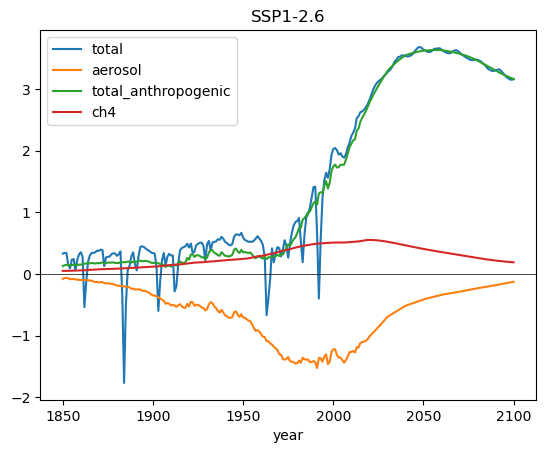

In [26]:
# Let's try a quick plot

df_forcing_126[['total', 'aerosol', 'total_anthropogenic', 'ch4']].plot()
plt.gca().axhline(0, color='k', lw=0.5)
plt.title("SSP1-2.6")
plt.show()


In [17]:
# What if we use SSP2-4.5 instead?
df_forcing_245 = pd.read_csv('files/ERF_ssp245_1750-2500.csv', index_col='year').loc[1850:2100]
df_forcing_245


,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,
1850,0.139966,0.049382,0.007358,7.958010e-08,0.030000,0.004539,0.000000,-0.006275,-0.071873,0.006886,-0.031205,0.194333,0.007528,0.128779,0.201861,0.330640
1851,0.142307,0.049486,0.007656,8.228277e-08,0.031016,0.004548,0.000000,-0.005063,-0.063404,0.006246,-0.031907,0.197859,0.002068,0.140886,0.199927,0.340813
1852,0.144956,0.049947,0.007954,8.533412e-08,0.032032,0.004591,0.000000,-0.004535,-0.059701,0.005972,-0.032610,0.191554,0.001257,0.148605,0.192811,0.341415
1853,0.147334,0.050708,0.008331,8.839851e-08,0.033049,0.004661,0.000000,-0.005117,-0.063726,0.006264,-0.033313,0.010986,-0.008868,0.148191,0.002118,0.150310
1854,0.149366,0.051522,0.008720,9.147118e-08,0.034065,0.004736,0.000000,-0.007101,-0.078993,0.007432,-0.034015,-0.022961,-0.022721,0.135732,-0.045682,0.090050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,4.390144,0.476364,0.345036,2.726912e-01,0.323995,0.043785,0.172465,-0.191842,-0.224062,0.010140,-0.185992,0.000000,-0.018021,5.432726,-0.018021,5.414704
2097,4.394430,0.475060,0.345397,2.716185e-01,0.322410,0.043665,0.174367,-0.191754,-0.219563,0.009602,-0.184654,0.000000,-0.025076,5.440580,-0.025076,5.415503
2098,4.398207,0.473818,0.345725,2.705311e-01,0.320832,0.043551,0.176269,-0.191665,-0.215159,0.009064,-0.183303,0.000000,-0.031632,5.447870,-0.031632,5.416238


In [18]:
# same as before - make a category for total aerosol radiative forcing: ERFaci + ERFari
df_forcing_245['aerosol'] = df_forcing_245['aerosol-cloud_interactions'] + df_forcing_245['aerosol-radiation_interactions']
df_forcing_245


,co2,ch4,n2o,other_wmghg,o3,h2o_stratospheric,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total,aerosol
year,,,,,,,,,,,,,,,,,
1850,0.139966,0.049382,0.007358,7.958010e-08,0.030000,0.004539,0.000000,-0.006275,-0.071873,0.006886,-0.031205,0.194333,0.007528,0.128779,0.201861,0.330640,-0.078147
1851,0.142307,0.049486,0.007656,8.228277e-08,0.031016,0.004548,0.000000,-0.005063,-0.063404,0.006246,-0.031907,0.197859,0.002068,0.140886,0.199927,0.340813,-0.068466
1852,0.144956,0.049947,0.007954,8.533412e-08,0.032032,0.004591,0.000000,-0.004535,-0.059701,0.005972,-0.032610,0.191554,0.001257,0.148605,0.192811,0.341415,-0.064236
1853,0.147334,0.050708,0.008331,8.839851e-08,0.033049,0.004661,0.000000,-0.005117,-0.063726,0.006264,-0.033313,0.010986,-0.008868,0.148191,0.002118,0.150310,-0.068843
1854,0.149366,0.051522,0.008720,9.147118e-08,0.034065,0.004736,0.000000,-0.007101,-0.078993,0.007432,-0.034015,-0.022961,-0.022721,0.135732,-0.045682,0.090050,-0.086094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,4.390144,0.476364,0.345036,2.726912e-01,0.323995,0.043785,0.172465,-0.191842,-0.224062,0.010140,-0.185992,0.000000,-0.018021,5.432726,-0.018021,5.414704,-0.415904
2097,4.394430,0.475060,0.345397,2.716185e-01,0.322410,0.043665,0.174367,-0.191754,-0.219563,0.009602,-0.184654,0.000000,-0.025076,5.440580,-0.025076,5.415503,-0.411317
2098,4.398207,0.473818,0.345725,2.705311e-01,0.320832,0.043551,0.176269,-0.191665,-0.215159,0.009064,-0.183303,0.000000,-0.031632,5.447870,-0.031632,5.416238,-0.406824


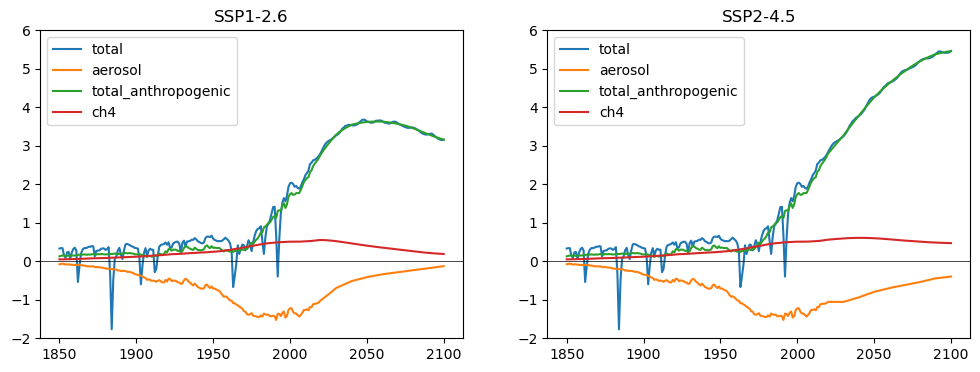

In [27]:
# Plot them side-by-side to compare

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

# SSP 1-2.6
ax1.plot(df_forcing_126['total'], color="C0", label="total")
ax1.plot(df_forcing_126['aerosol'], color="C1", label="aerosol")
ax1.plot(df_forcing_126['total_anthropogenic'], color="C2", label="total_anthropogenic")
ax1.plot(df_forcing_126['ch4'], color="C3", label="ch4")
ax1.axhline(0, color='k', lw=0.5)
ax1.set_title("SSP1-2.6")

# SSP 2-4.5
ax2.plot(df_forcing_245['total'], color="C0", label="total")
ax2.plot(df_forcing_245['aerosol'], color="C1", label="aerosol")
ax2.plot(df_forcing_245['total_anthropogenic'], color="C2", label="total_anthropogenic")
ax2.plot(df_forcing_245['ch4'], color="C3", label="ch4")
ax2.axhline(0, color='k', lw=0.5)
ax2.set_title("SSP2-4.5")

for ax in [ax1, ax2]:
    ax.legend(loc="upper left")
    ax.set_ylim(-2, 6)
    
plt.show()


## Part 2: Setup - coupled model parameters

In [69]:
# physical model parameters
all_model_params = pd.read_csv('files/4xCO2_cummins_ebm3.csv',index_col=['model'])
all_model_params


,run,conv,nit,gamma,C1,C2,C3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,F_4xCO2
model,,,,,,,,,,,,,,
CAMS-CSM1-0,r1i1p1f1,True,4809,28.239872,2.632439,9.262195,52.927697,1.876254,5.153591,0.643546,1.285458,2.690512,0.439493,8.870602
GISS-E2-2-G,r1i1p1f1,True,3965,2.385368,3.601142,11.333337,313.520678,1.972359,1.922481,0.631276,0.443575,0.544189,0.535407,8.035197
NorESM2-LM,r1i1p1f1,True,1966,1.633858,4.487727,125.070697,0.041775,1.603670,0.823165,1.596259,0.836880,1.343506,0.698845,7.845990
ACCESS-ESM1-5,r1i1p1f1,True,3517,2.742392,3.767727,8.922353,87.066320,0.699550,3.583351,0.842623,1.557784,0.636709,0.604740,6.557606
HadGEM3-GC31-LL,r1i1p1f3,True,5953,3.129576,3.868931,9.254582,66.399919,0.611179,2.851391,0.642237,1.174268,0.457505,0.611576,7.222087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TaiESM1,r1i1p1f1,True,6231,2.044911,5.064045,8.999461,91.069184,0.873504,2.314369,0.919607,1.233673,0.461613,0.687217,8.150058
NorESM2-MM,r1i1p1f1,True,2562,1.480571,4.121854,121.675907,0.049259,1.961781,0.788035,2.112814,0.528932,1.310908,0.661117,9.113671
HadGEM3-GC31-MM,r1i1p1f3,True,4790,3.131744,3.396641,14.143754,64.570893,0.646049,2.007478,0.693694,1.041912,0.497626,0.433937,7.159394


In [70]:
# Let's pick one model to start with - CESM2
cesm2_params = all_model_params.loc['CESM2']
cesm2_params

run           r1i1p1f1
conv              True
nit               3183
gamma         2.796757
C1            4.830712
C2            6.397801
C3           71.294445
kappa1        0.649448
kappa2        3.876076
kappa3        0.900808
epsilon       1.678583
sigma_eta     0.713515
sigma_xi      0.491656
F_4xCO2       8.175245
Name: CESM2, dtype: object

## Part 3: Running the model

In [37]:
# We want to use FaIR's EnergyBalanceModel() class. How do we set this up?
EnergyBalanceModel?


Init signature:
EnergyBalanceModel(
    ocean_heat_capacity,
    ocean_heat_transfer,
    deep_ocean_efficacy=1,
    forcing_4co2=8,
    stochastic_run=False,
    sigma_eta=0.5,
    sigma_xi=0.5,
    gamma_autocorrelation=2,
    seed=None,
    timestep=1,
    n_timesteps=1,
)
Docstring:     
Energy balance model that converts forcing to temperature.

The energy balance model is converted to an impulse-response formulation
(hence the IR part of FaIR) to allow efficient evaluation. The benefits of
this are increased as once derived, the "layers" of the energy balance
model do not communicate with each other. The model description can be
found in [Leach2021]_, [Cummins2020]_, [Tsutsui2017]_ and [Geoffroy2013]_.

Parameters
----------
ocean_heat_capacity : ``np.ndarray``
    Ocean heat capacity of each layer (top first), W m-2 yr K-1
ocean_heat_transfer : ``np.ndarray``
    Heat exchange coefficient between ocean layers (top first). The
    first element of this array is akin to the climat

In [62]:
# Let's use CESM2 parameters for each of the input parameters

ebm3 = EnergyBalanceModel(
    ocean_heat_capacity=[cesm2_params.C1, cesm2_params.C2, cesm2_params.C3],
    ocean_heat_transfer=[cesm2_params.kappa1, cesm2_params.kappa2, cesm2_params.kappa2],
    deep_ocean_efficacy=cesm2_params.epsilon,  
    gamma_autocorrelation=cesm2_params.gamma,  
    sigma_xi=cesm2_params.sigma_xi,
    sigma_eta=cesm2_params.sigma_eta,
    forcing_4co2=cesm2_params.F_4xCO2,
    stochastic_run=False,

    # We want to set a seed for reproduciblity. This can be any number.
    seed=16
)


# TODO: what does stochastic_run=True do?
# TODO: why are there 3 temperature columns?

In [63]:
# We have the model initialized... but we need to give it some forcings!
# An easy place to start is to use the total forcing from SSP1-2.6 - everything that goes into AR6
ebm3.add_forcing(forcing = df_forcing_126['total'].values, timestep=1)


In [64]:
# BUT we haven't actually run the model yet! It gives us nothing for tmeperature. 
ebm3.temperature

array([[0., 0., 0., 0.]])

In [65]:
# Now we can run it! 
ebm3.run()

# this gives us something exciting for temperature
ebm3.temperature


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.34558735e-02,  5.76006379e-03,  9.87173838e-05],
       [ 6.43379774e-02,  1.75466652e-02,  7.13000190e-04],
       [ 8.31842272e-02,  2.72279549e-02,  1.87616337e-03],
       [ 7.54656532e-02,  3.07076654e-02,  3.35319622e-03],
       [ 5.95864319e-02,  2.77843841e-02,  4.73840970e-03],
       [ 6.33086556e-02,  2.64048578e-02,  5.89295286e-03],
       [ 7.11543222e-02,  2.90415507e-02,  7.04177606e-03],
       [ 5.80956564e-02,  2.88786625e-02,  8.23359990e-03],
       [ 6.17589704e-02,  2.78277681e-02,  9.27222376e-03],
       [ 7.85110637e-02,  3.20745397e-02,  1.03469593e-02],
       [ 9.52827327e-02,  3.87164685e-02,  1.16704930e-02],
       [ 9.91372954e-02,  4.35386727e-02,  1.32491788e-02],
       [ 1.71390839e-02,  3.13724204e-02,  1.46684842e-02],
       [-1.43591895e-02,  1.13060182e-02,  1.49451227e-02],
       [ 1.25139973e-02,  9.76626881e-03,  1.46246221e-02],
       [ 4.84655788e-02,  1.99295027e-02

In [67]:
# Put the output temperature projections into a data frame for easier plotting/analysis
ebm_tas = pd.Series(data=ebm3.temperature[:,0], index=df_forcing_126.index)


<Axes: xlabel='year'>

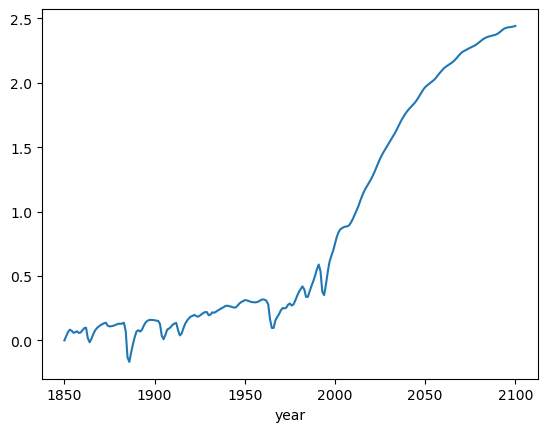

In [68]:
ebm_tas.plot()

## Part 4: Experiments

In [81]:
# To make this easier, let's make a function where we can input the total forcing and model
# parameters and output the temperature time series.

def run_fair(forcing=df_forcing_ssp126['total'], model_params=all_model_params.loc['CESM2']):
    """ 
    Run FaIR to get a projected temperature change for some model parameters
    and some input forcing. Defaults to CESM2 and the SSP1-2.6 total forcing.
    """
    ebm = EnergyBalanceModel(
            ocean_heat_capacity=[model_params.C1, model_params.C2, model_params.C3],
            ocean_heat_transfer=[model_params.kappa1, model_params.kappa2, model_params.kappa2],
            deep_ocean_efficacy=model_params.epsilon, 
            gamma_autocorrelation=model_params.gamma,  
            sigma_xi=model_params.sigma_xi,
            sigma_eta=model_params.sigma_eta,
            forcing_4co2=model_params.F_4xCO2,
            stochastic_run=False,
            seed=16
        )

    ebm.add_forcing(forcing=forcing.values, timestep=1)
    ebm.run()
    
    ebm_tas = pd.Series(data=ebm.temperature[:, 0], index=forcing.index)

    return ebm_tas
    

<Axes: xlabel='year'>

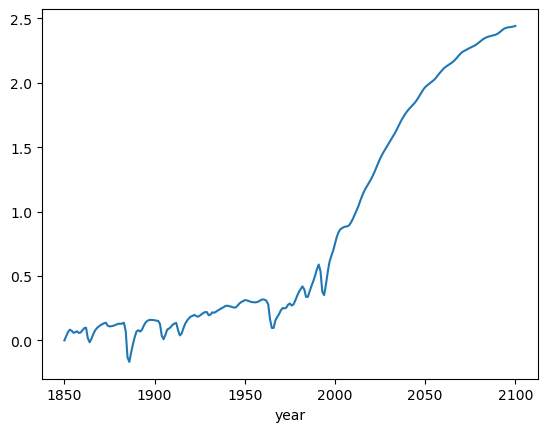

In [83]:
# This should give us the same thing as before:
ebm_tas_cesm2 = run_fair()
ebm_tas_cesm2.plot()

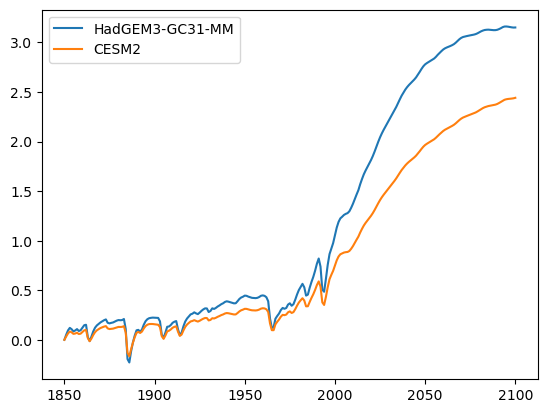

In [87]:
# Same forcings, different model
ebm_tas_hadgem = run_fair(model_params=all_model_params.loc["HadGEM3-GC31-MM"])

plt.plot(ebm_tas_hadgem, label="HadGEM3-GC31-MM")
plt.plot(ebm_tas_cesm2, label="CESM2")
plt.legend()
plt.show()


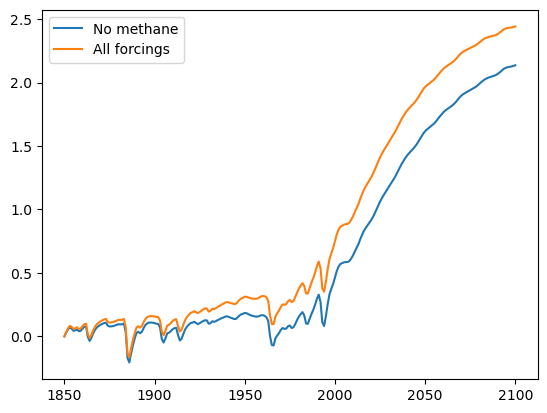

In [93]:
# WHat if we take away methane?
# We need to give fair input for ALL forcings except methane (CH4)

forcing_noch4 = df_forcing_ssp126['total'] - df_forcing_ssp126['ch4']

ebm_tas_cesm2_noch4 = run_fair(forcing=forcing_noch4)

plt.plot(ebm_tas_cesm2_noch4, label="No methane")
plt.plot(ebm_tas_cesm2, label="All forcings")
plt.legend()
plt.show()


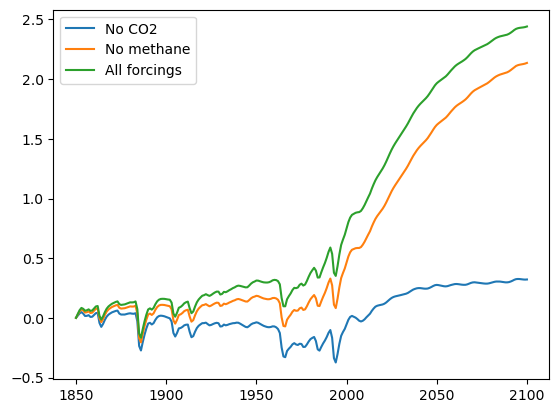

In [94]:
# WHat if we take away co2?
# We need to give fair input for ALL forcings except co2

forcing_noco2 = df_forcing_ssp126['total'] - df_forcing_ssp126['co2']

ebm_tas_cesm2_noco2 = run_fair(forcing=forcing_noco2)

plt.plot(ebm_tas_cesm2_noco2, label="No CO2")
plt.plot(ebm_tas_cesm2_noch4, label="No methane")
plt.plot(ebm_tas_cesm2, label="All forcings")
plt.legend()
plt.show()
